# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from functions import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, MinMaxScaler
from sklearn import preprocessing
import scipy.stats as stats
from scipy.special import inv_boxcox
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as ticker
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
warnings.filterwarnings('ignore')

In [2]:
rent_df = pd.read_csv('/Users/ignaciolorenzoqueralt/Documents/Ironhack/Final Project/properties/rent/2021.11.17_cataluña_1300_5.csv', engine='python' )
rent_df = rent_df.loc[:, ~rent_df.columns.str.contains('^Unnamed')]

# Working on the data

### Adding sqm price for each neighborhood

In [3]:
rent_df['hood_price_m2'] = ""

for index, row in rent_df.iterrows():
    hood_price_m2 = rent_df[rent_df['neighborhood'] == rent_df['neighborhood'][index]]['price_m2'].mean()
    rent_df['hood_price_m2'][index] = hood_price_m2

### Cleaning the data

- Replacing nulls from last_update:

In [4]:
clean_last_update(rent_df, c = 'last_update')

- Replacing null values of lift column with 'no'. All properties with no lift data don't have a lift.

In [5]:
fill_lift_column(rent_df)

- Dealing with null values

In [6]:
checking_nulls(rent_df)

The column  area  has  11  null values
The column  floor  has  2511  null values
The column  ccaa  has  22  null values
The column  description  has  11  null values
The column  geo_town  has  36  null values
The column  m2  has  36  null values
The column  n_bath  has  36  null values
The column  n_rooms  has  36  null values
The column  name  has  36  null values
The column  neighborhood  has  36  null values
The column  opportunity  has  36  null values
The column  price  has  36  null values
The column  price_m2  has  61  null values
The column  price_reduction  has  61  null values
The column  province  has  61  null values
The column  url  has  61  null values
The column  hood_price_m2  has  61  null values


In [7]:
rent_df = rent_df.dropna()

- Creating df with the neighborhoods of the df and its hood_price_m2:

In [8]:
neighborhood_price_sqm = rent_df[['neighborhood','geo_town','hood_price_m2']].copy()
neighborhood_price_sqm.drop_duplicates(keep=False,inplace=True)
neighborhood_price_sqm = neighborhood_price_sqm.reset_index(drop=True)
neighborhood_price_sqm.head(3)

,neighborhood,geo_town,hood_price_m2
0,Zona alta,arenys_de_mar,9.333333
1,Nucli Urbà,argentona,8.384615
2,Montigalà,badalona,12.0


- Cleaning numerical variables

In [9]:
numericals = ['m2', 'n_rooms', 'n_bath', 'price_m2', 'price', 'price_reduction', 'last_update', 'hood_price_m2']
convert_to_numerical(rent_df, numericals)

- Filtering out towns in which there are less than x properties listed.

In [10]:
filtered_towns = list(rent_df['geo_town'].value_counts()[lambda x: x > 10].index)
rent_df = rent_df[rent_df['geo_town'].isin(filtered_towns)]

# Exploratory analysis

In [11]:
rent_df.head(3)

,area,floor,ccaa,description,geo_town,last_update,lift,m2,n_bath,n_rooms,name,neighborhood,opportunity,price,price_m2,price_reduction,province,url,hood_price_m2
1,Arenys de Mar,first,cataluña,INMUEBLE NO SUJETO A LA LIMITACIÓN DE PRECIOS ...,arenys_de_mar,0,yes,70,1,3,Alquiler Apartamento N ii junquera. Por meses...,Urbanitzacions,no,900,12,80,barcelona,https://www.habitaclia.com/alquiler-apartament...,9
2,Arenys de Mar,fourth,cataluña,Vivienda en la Urbanización Carolines de Areny...,arenys_de_mar,8,yes,89,1,2,"Alquiler Piso en Carrer mig (del), 20. Vivie...",Urbanitzacions,no,680,7,20,barcelona,https://www.habitaclia.com/alquiler-piso-vivie...,9
4,Arenys de Mar,second,cataluña,ALQUILER DE TEMPORADA - Bonito piso de 70 m2 t...,arenys_de_mar,13,yes,70,1,3,Alquiler Apartamento Carrer camí ral del caba...,Urbanitzacions,no,900,12,80,barcelona,https://www.habitaclia.com/alquiler-apartament...,9


In [12]:
rent_df.shape

(2276, 19)

In [13]:
rent_df.dtypes

area               object
floor              object
ccaa               object
description        object
geo_town           object
last_update         int64
lift               object
m2                  int64
n_bath              int64
n_rooms             int64
name               object
neighborhood       object
opportunity        object
price               int64
price_m2            int64
price_reduction     int64
province           object
url                object
hood_price_m2       int64
dtype: object

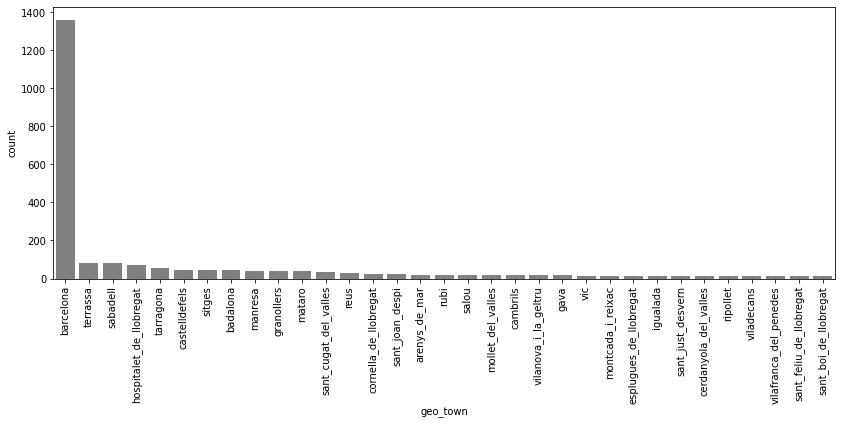

In [14]:
countplot(rent_df,c = "geo_town")

# Models:

#### Separating big from small cities

In [15]:
model_df_small = rent_df[rent_df['geo_town'] != filtering_big_cities(rent_df)]
model_df_big = rent_df[rent_df['geo_town'] == filtering_big_cities(rent_df)]

#### Feature selection for big and small cities:

We skip neighborhood as it would add too many distinct categorical values which would increase too much the size of the model when encoding it.

In [16]:
model_df_small = model_df_small[['m2', 'n_rooms', 'n_bath', 'last_update', 'geo_town', 'province', 'ccaa', 'price', 'lift', 'floor', 'hood_price_m2']].copy()
model_df_big = model_df_big[['geo_town', 'm2', 'n_rooms', 'n_bath', 'last_update', 'price', 'lift', 'floor', 'hood_price_m2', 'neighborhood']].copy()

#### Removing outliers

In [17]:
model_df_small = remove_outliers(model_df_small, threshold=1.5, in_columns = ['m2', 'n_rooms', 'last_update', 'price', 'hood_price_m2'])
model_df_big = remove_outliers(model_df_big, threshold=1.5, in_columns = ['m2', 'n_rooms', 'last_update', 'price', 'hood_price_m2'])

In [18]:
model_df_small.shape

(693, 11)

In [19]:
model_df_big.shape

(1297, 10)

#### Visualizing our data

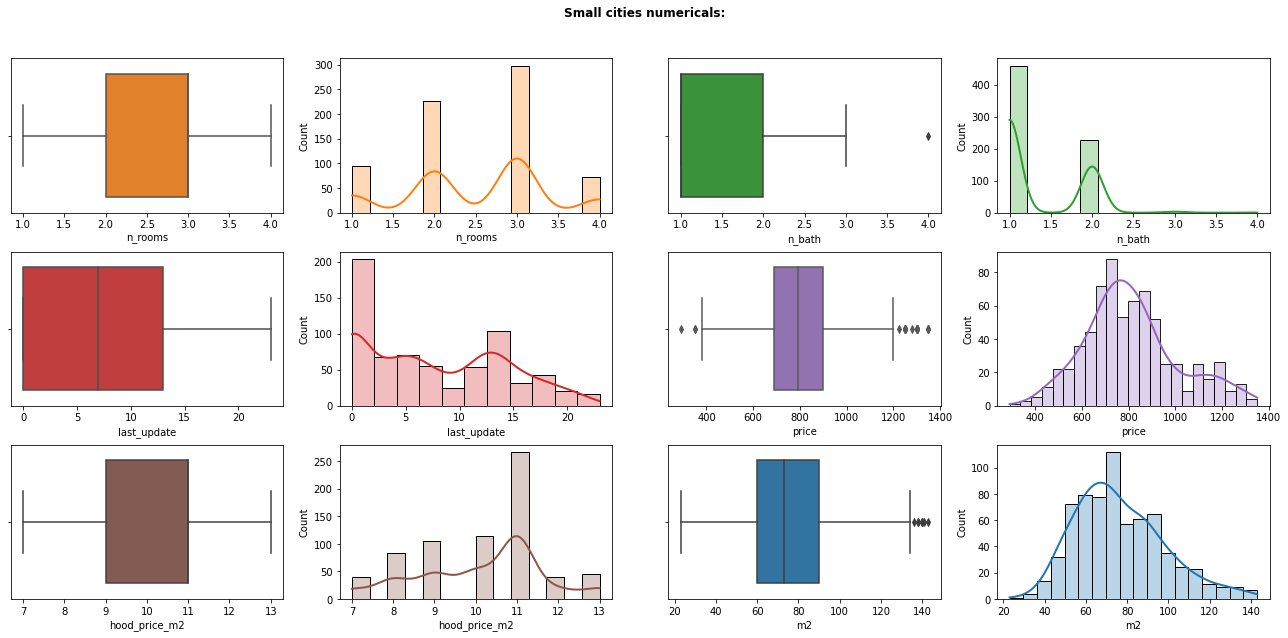

In [20]:
plot_numericals(model_df_small, title = "Small cities numericals:")

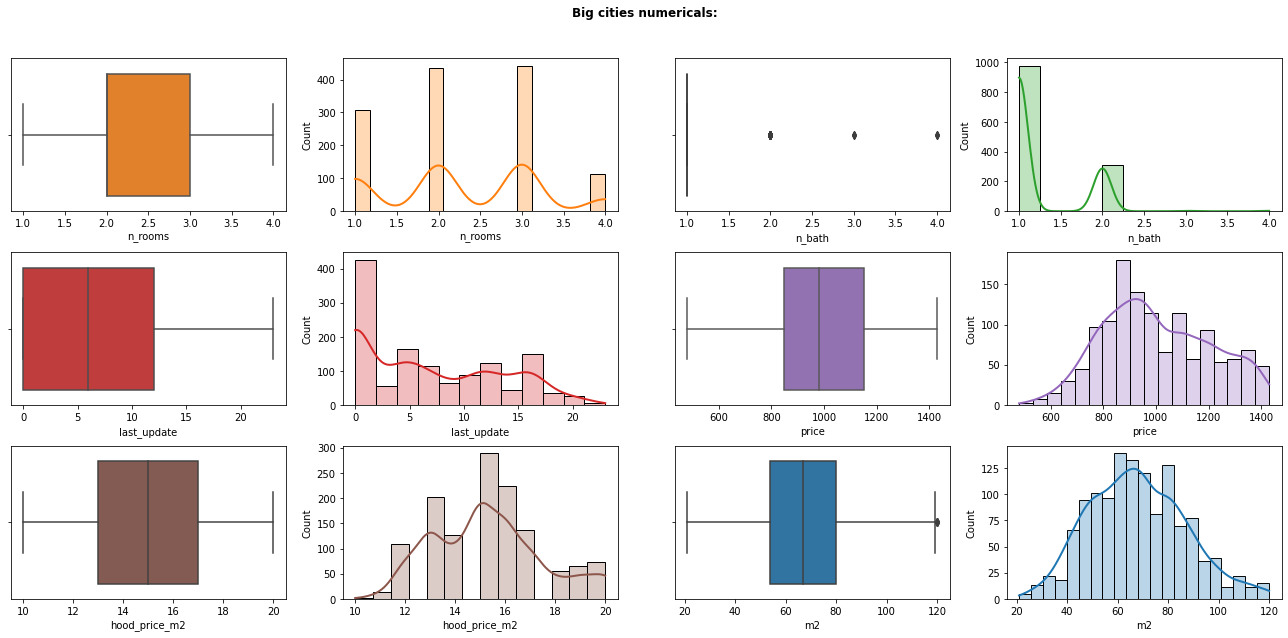

In [21]:
plot_numericals(model_df_big, title = "Big cities numericals:")

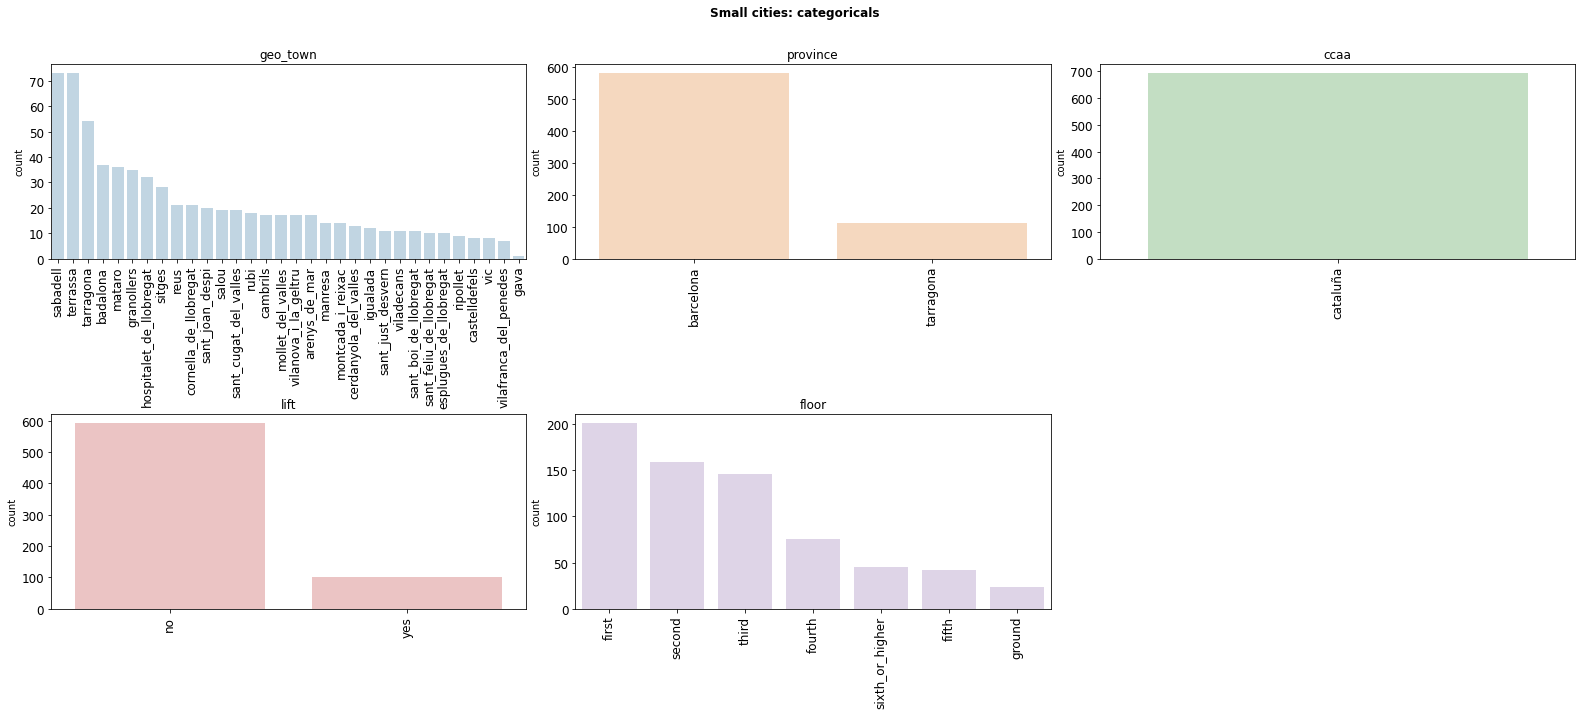

In [22]:
plot_categorical(model_df_small, title = "Small cities: categoricals", delete_n = [5])

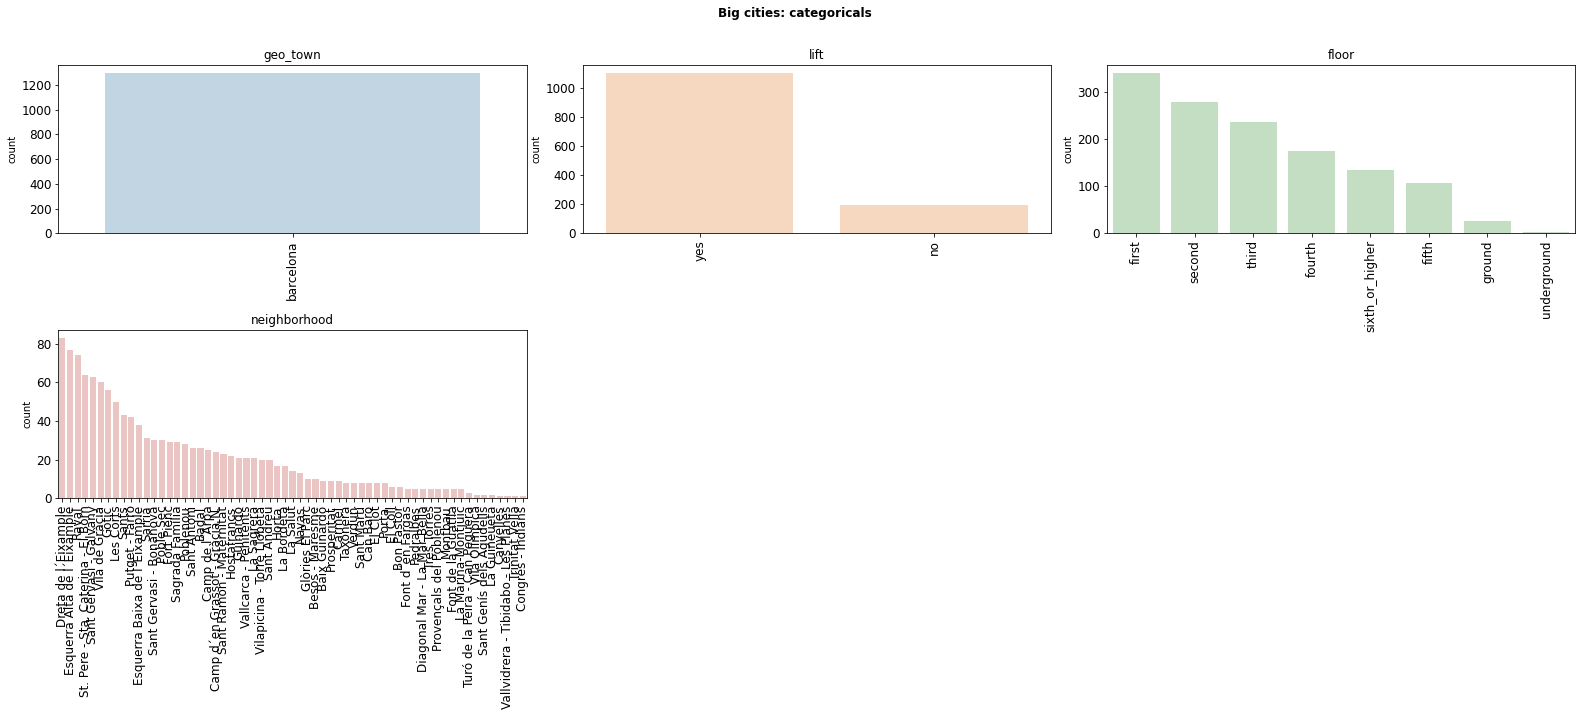

In [23]:
plot_categorical(model_df_big, title = "Big cities: categoricals", delete_n = [4,5])

#### X-y Split

In [24]:
X_sma = model_df_small.drop('price', axis=1)
y_sma = model_df_small[['price']].copy()

X_big = model_df_big.drop('price', axis=1)
y_big = model_df_big[['price']].copy()

#### Encoding categoricals and normalizing numericals

In [25]:
X_sma_cat = X_sma.select_dtypes('object')
X_sma_num = X_sma.select_dtypes('int')

X_sma_cat_enc = pd.get_dummies(X_sma_cat, drop_first=True)
X_sma_num_norm, _ci = boxcox_transform(X_sma_num)

X_sma = np.concatenate([X_sma_num_norm, X_sma_cat_enc], axis=1)
X_sma.shape

(693, 44)

In [26]:
X_big_cat = X_big.select_dtypes('object')
X_big_num = X_big.select_dtypes('int')

X_big_cat_enc = pd.get_dummies(X_big_cat, drop_first=True)
X_big_num_norm, _ci = boxcox_transform(X_big_num)

X_big = np.concatenate([X_big_num_norm, X_big_cat_enc], axis=1)
X_big.shape

(1297, 73)

#### Train-test split

In [27]:
X_sma_train, X_sma_test, y_sma_train, y_sma_test = train_test_split(X_sma, y_sma, test_size=0.3, random_state=10)
X_big_train, X_big_test, y_big_train, y_big_test = train_test_split(X_big, y_big, test_size=0.3, random_state=10)

#### Finding the best algorithm for the big and small city model.

In [28]:
model_comparisson = pd.DataFrame(columns = ['city_type', 'model', 'r2', 'mean_absolute_error', 'mean_squared_error'])

In [29]:
pipe = Pipeline(steps=[('estimator', LinearRegression())])
"""
params_grid = [ {'estimator':[LinearRegression()],
                },
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[10, 50, 100, 200, 300, 500, 600],
                'estimator__max_depth':[1, 2, 3, 4, 5, 6, 7, None],
                'estimator__min_samples_split':[2, 3, 4, 5, None],
                'estimator__min_samples_leaf':[1, 2, 3, 4, 5],
               }
              ]
"""
params_grid = [
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[10],
                'estimator__max_depth':[1, 2],
                'estimator__min_samples_split':[2, 3],
                'estimator__min_samples_leaf':[1, 2],
               }
              ]

grid = GridSearchCV(pipe, params_grid, n_jobs =-1, verbose = 2)
res = grid.fit(X_sma, y_sma)

grid.best_params_

sma_grid_results = pd.DataFrame(grid.cv_results_)
sma_grid_results = sma_grid_results.sort_values(by="rank_test_score", ignore_index=True)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [30]:
pipe = Pipeline(steps=[('estimator', LinearRegression())])
"""
params_grid = [ {'estimator':[LinearRegression()],
                },
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[10, 50, 100, 200, 300, 500, 600],
                'estimator__max_depth':[1, 2, 3, 4, 5, 6, 7, None],
                'estimator__min_samples_split':[2, 3, 4, 5, None],
                'estimator__min_samples_leaf':[1, 2, 3, 4, 5],
               }
              ]
"""
params_grid = [
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[10],
                'estimator__max_depth':[1, 2],
                'estimator__min_samples_split':[2, 3],
                'estimator__min_samples_leaf':[1, 2],
               }
              ]

grid = GridSearchCV(pipe, params_grid, n_jobs =-1, verbose = 2)
res = grid.fit(X_big, y_big)

grid.best_params_

big_grid_results = pd.DataFrame(grid.cv_results_)
big_grid_results = big_grid_results.sort_values(by="rank_test_score", ignore_index=True)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [31]:
sma_grid_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024971,0.000387,0.003821,0.000080,"RandomForestRegressor(max_depth=2, min_samples...",2,1,3,10,{'estimator': RandomForestRegressor(max_depth=...,0.413550,0.278350,0.226686,0.261218,-0.310694,0.173822,0.250433,1
1,0.027888,0.002036,0.004856,0.001417,"RandomForestRegressor(max_depth=2, min_samples...",2,2,2,10,{'estimator': RandomForestRegressor(max_depth=...,0.414747,0.230049,0.218104,0.255154,-0.259535,0.171704,0.226962,2
2,0.024982,0.000431,0.004014,0.000281,"RandomForestRegressor(max_depth=2, min_samples...",2,1,2,10,{'estimator': RandomForestRegressor(max_depth=...,0.401504,0.227877,0.231927,0.245817,-0.285246,0.164376,0.233931,3


In [32]:
big_grid_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032367,0.002867,0.004603,0.000900,"RandomForestRegressor(max_depth=2, min_samples...",2,2,2,10,{'estimator': RandomForestRegressor(max_depth=...,0.295591,0.352183,0.288854,-0.135520,0.237732,0.207768,0.175435,1
1,0.032262,0.007712,0.003351,0.000813,"RandomForestRegressor(max_depth=2, min_samples...",2,2,3,10,{'estimator': RandomForestRegressor(max_depth=...,0.324477,0.349677,0.297688,-0.151743,0.202878,0.204595,0.184968,2
2,0.033117,0.003798,0.004063,0.000198,"RandomForestRegressor(max_depth=2, min_samples...",2,1,2,10,{'estimator': RandomForestRegressor(max_depth=...,0.262272,0.349346,0.275810,-0.146296,0.217928,0.191812,0.174262,3


#### Fitting LinearRegression to Big & Small data

In [33]:
# Fitting the model
reg_sma_city = LinearRegression()
reg_big_city = LinearRegression()

reg_sma_city.fit(X_sma_train, y_sma_train)
reg_big_city.fit(X_big_train, y_big_train)

# Making predictions
reg_sma_predictions = reg_sma_city.predict(X_sma_test)
reg_big_predictions = reg_big_city.predict(X_big_test)

# Getting the R2
reg_sma_r2 = r2_score(y_sma_test, reg_sma_predictions)
reg_big_r2 = r2_score(y_big_test, reg_big_predictions)

# Appending the model information to a df which we will use to evaluate our different models
row_reg_sma_r2 = {'city_type':'small', 'model':reg_sma_city, 'r2':reg_sma_r2, 'mean_absolute_error':mean_absolute_error(y_sma_test, reg_sma_predictions), 'mean_squared_error':mean_squared_error(y_sma_test, reg_sma_predictions, squared=False)}
row_reg_big_r2 = {'city_type':'big', 'model':reg_big_city, 'r2':reg_big_r2, 'mean_absolute_error':mean_absolute_error(y_big_test, reg_big_predictions), 'mean_squared_error':mean_squared_error(y_big_test, reg_big_predictions, squared=False)}

model_comparisson = model_comparisson.append(row_reg_sma_r2, ignore_index=True)
model_comparisson = model_comparisson.append(row_reg_big_r2, ignore_index=True)

#### Fitting the best RandomForestRegressor() to Big & Small data

In [34]:
# Fitting the model
rf_sma_city = sma_grid_results['param_estimator'][0]
rf_big_city = big_grid_results['param_estimator'][0]

rf_sma_city.fit(X_sma_train, y_sma_train)
rf_big_city.fit(X_big_train, y_big_train)

# Making predictions
rf_sma_predictions = rf_sma_city.predict(X_sma_test)
rf_big_predictions = rf_big_city.predict(X_big_test)

# Getting the R2
rf_sma_r2 = metrics.r2_score(y_sma_test, rf_sma_predictions)
rf_big_r2 = metrics.r2_score(y_big_test, rf_big_predictions)

# Appending the model information to a df which we will use to evaluate our different models
row_rf_sma_r2 = {'city_type':'small', 'model':rf_sma_city, 'r2':rf_sma_r2, 'mean_absolute_error':mean_absolute_error(y_sma_test, rf_sma_predictions), 'mean_squared_error':mean_squared_error(y_sma_test, rf_sma_predictions, squared=False)}
row_rf_big_r2 = {'city_type':'big', 'model':rf_big_city, 'r2':rf_big_r2, 'mean_absolute_error':mean_absolute_error(y_big_test, rf_big_predictions), 'mean_squared_error':mean_squared_error(y_big_test, rf_big_predictions, squared=False)}

model_comparisson = model_comparisson.append(row_rf_sma_r2, ignore_index=True)
model_comparisson = model_comparisson.append(row_rf_big_r2, ignore_index=True)
model_comparisson=model_comparisson.sort_values(by=['city_type','r2'], ignore_index=True)

#### Comparing the performance of the different models

In [35]:
model_comparisson

,city_type,model,r2,mean_absolute_error,mean_squared_error
0,big,"(DecisionTreeRegressor(max_depth=2, max_featur...",0.261227,142.345606,173.589326
1,big,LinearRegression(),0.445633,120.024710,150.371673
2,small,"(DecisionTreeRegressor(max_depth=2, max_featur...",0.453593,124.577711,158.562397
3,small,LinearRegression(),0.682355,93.438906,120.896261


In [36]:
# Adding predictions to the test df
y_sma_test['reg_predicted'] = reg_sma_predictions
y_sma_test['rf_predicted'] = rf_sma_predictions

y_big_test['reg_predicted'] = reg_big_predictions
y_big_test['rf_predicted'] = rf_big_predictions

# Calculating % difference between the predicted value and the real value
y_sma_test['reg_difference_%'] = ((y_sma_test['reg_predicted']-y_sma_test['price'])/y_sma_test['reg_predicted'])*100
y_sma_test['rf_difference_%'] = ((y_sma_test['rf_predicted']-y_sma_test['price'])/y_sma_test['rf_predicted'])*100

y_big_test['reg_difference_%'] = ((y_big_test['reg_predicted']-y_big_test['price'])/y_big_test['reg_predicted'])*100
y_big_test['rf_difference_%'] = ((y_big_test['rf_predicted']-y_big_test['price'])/y_big_test['rf_predicted'])*100

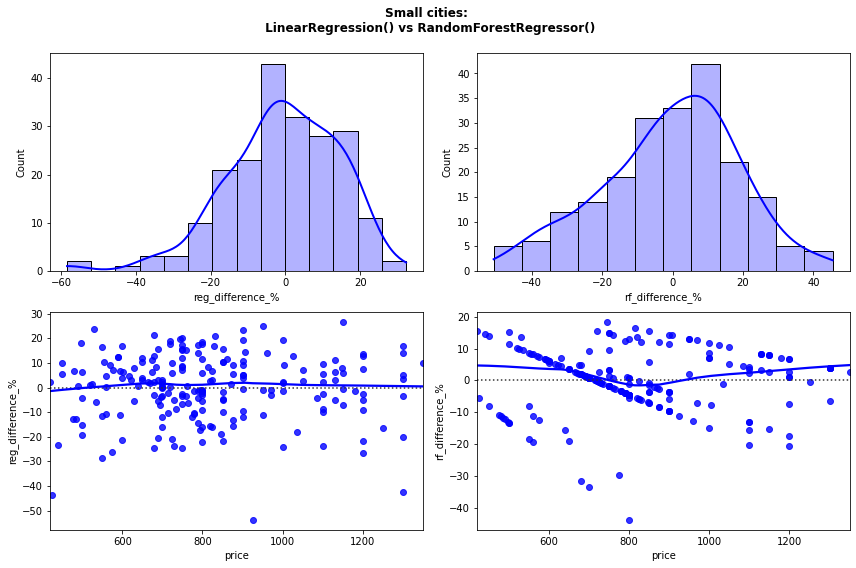

In [37]:
model_plots(y_sma_test, title = "Small cities: \n LinearRegression() vs RandomForestRegressor()")

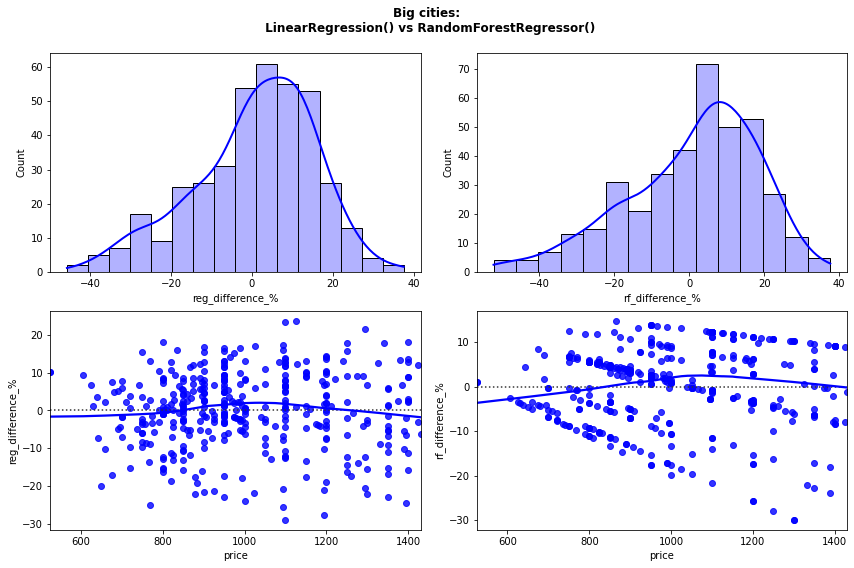

In [38]:
model_plots(y_big_test, title = "Big cities: \n LinearRegression() vs RandomForestRegressor()")

Small cities: Linear Regression jointplot


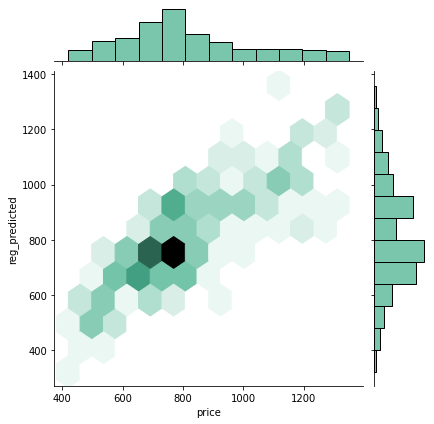

In [39]:
sns.jointplot(x=y_sma_test.price, y=y_sma_test.reg_predicted, kind="hex", color="#4CB391")
print("Small cities: Linear Regression jointplot")

Big cities: RanfomForestRegression jointplot


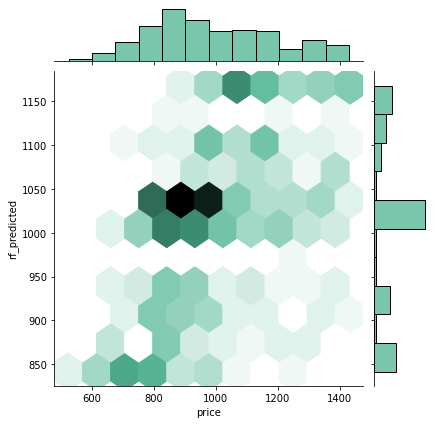

In [40]:
sns.jointplot(x=y_big_test.price, y=y_big_test.rf_predicted, kind="hex", color="#4CB391")
print("Big cities: RanfomForestRegression jointplot")


#### Evaluating variables

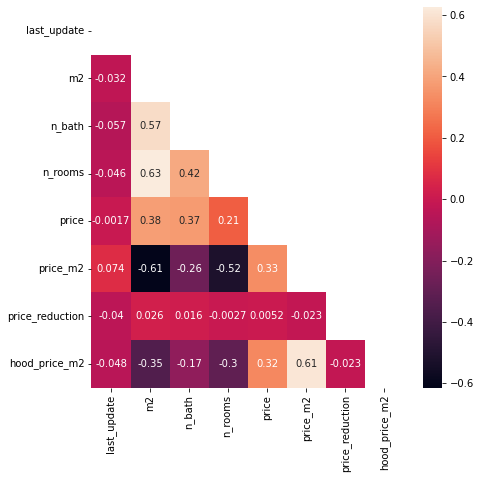

In [41]:
# check the correlations
mask = np.zeros_like(rent_df.corr())
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(rent_df.corr(), mask=mask, annot=True)
plt.show()

In [42]:
# Evaluating the importance of the different columns for each RandomForestRegressor model

X_sma = model_df_small.drop('price', axis=1)
y_sma = model_df_small[['price']].copy()

X_big = model_df_big.drop('price', axis=1)
y_big = model_df_big[['price']].copy()

feature_list_sma = list(X_sma.columns)
feature_list_big = list(X_big.columns)

importances_sma = list(rf_sma_city.feature_importances_)
importances_big = list(rf_big_city.feature_importances_)

feature_importances_sma = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_sma, importances_sma)]
feature_importances_sma = sorted(feature_importances_sma, key = lambda x: x[1], reverse = True)
print("Small city:")
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_sma]
print('\n')

print("Big city:")
feature_importances_big = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_big, importances_big)]
feature_importances_big = sorted(feature_importances_big, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_big]


Small city:
Variable: n_bath               Importance: 0.5
Variable: m2                   Importance: 0.11
Variable: geo_town             Importance: 0.08
Variable: n_rooms              Importance: 0.0
Variable: last_update          Importance: 0.0
Variable: province             Importance: 0.0
Variable: ccaa                 Importance: 0.0
Variable: lift                 Importance: 0.0
Variable: floor                Importance: 0.0
Variable: hood_price_m2        Importance: 0.0


Big city:
Variable: geo_town             Importance: 0.66
Variable: n_rooms              Importance: 0.18
Variable: n_bath               Importance: 0.16
Variable: m2                   Importance: 0.0
Variable: last_update          Importance: 0.0
Variable: lift                 Importance: 0.0
Variable: floor                Importance: 0.0
Variable: hood_price_m2        Importance: 0.0
Variable: neighborhood         Importance: 0.0


[None, None, None, None, None, None, None, None, None]

## Finding the most profitable towns to Buy & Rent

### Importing df with properties for sale

In [43]:
df_sale = pd.read_csv('/Users/ignaciolorenzoqueralt/Documents/Ironhack/Final Project/properties/sale/2021.11.15_cataluña_90000_10.csv', engine = 'python')

### Separating properties that belong to big and small cities

In [44]:
df_sale_big = df_sale[df_sale['geo_town'] == filtering_big_cities(rent_df)]
df_sale_sma = df_sale[df_sale['geo_town'] != filtering_big_cities(rent_df)]

### Cleaning sale dfs

In [45]:
# Cleaning data following the process explained in the model part
clean_last_update(df_sale_big, c = 'last_update')
clean_last_update(df_sale_sma, c = 'last_update')

fill_lift_column(df_sale_big)
fill_lift_column(df_sale_sma)

df_sale_big = df_sale_big.merge(neighborhood_price_sqm, on='neighborhood', how='inner')
df_sale_sma = df_sale_sma.merge(neighborhood_price_sqm, on='neighborhood', how='inner')

df_sale_big = df_sale_big.dropna()
df_sale_sma = df_sale_sma.dropna()

In [46]:
# Checking the shape of the DFs
print('df_sale_big shape: ', df_sale_big.shape)
print('df_sale_sma shape: ', df_sale_sma.shape)

df_sale_big shape:  (12, 21)
df_sale_sma shape:  (3059, 21)


In [47]:
# Creating copies of the dfs
df_sale_big1 = df_sale_big.copy()
df_sale_sma1 = df_sale_sma.copy()

In [48]:
# Renaming the important column names which have been altered during the cleaning process
df_sale_sma1.columns = ['Unnamed: 0', 'name', 'floor', 'area', 'neighborhood', 'geo_town',
       'm2', 'n_rooms', 'n_bath', 'price_m2', 'price', 'price_reduction',
       'opportunity', 'last_update', 'description', 'url', 'lift', 'province',
       'ccaa', 'geo_town_y', 'hood_price_m2']

df_sale_big1.columns = ['Unnamed: 0', 'name', 'floor', 'area', 'neighborhood', 'geo_town',
       'm2', 'n_rooms', 'n_bath', 'price_m2', 'price', 'price_reduction',
       'opportunity', 'last_update', 'description', 'url', 'lift', 'province',
       'ccaa', 'geo_town_y', 'hood_price_m2']

In [49]:
# Selecting columns required for the model
for i in df_sale_sma1.columns:
    if i not in model_df_small.columns:
        df_sale_sma1 = df_sale_sma1.drop([i], axis = 1)
for i in df_sale_big1.columns:
    if i not in model_df_big.columns:
        df_sale_big1 = df_sale_big1.drop([i], axis = 1)

In [50]:
# Cleaning numerical columns
numericals = ['m2', 'n_rooms', 'n_bath', 'price', 'last_update', 'hood_price_m2']

convert_to_numerical(df_sale_sma1, numericals)
convert_to_numerical(df_sale_big1, numericals)

In [51]:
# Adding a column to the dfs to differenciate for rent vs for sale when we merge them to make predictions 
df_sale_big1['df']='sale'
model_df_big['df']='rent'

df_sale_sma1['df']='sale'
model_df_small['df']='rent'

In [52]:
# Merging properties for sale and for rent
big_merged_df = pd.concat([df_sale_big1, model_df_big], ignore_index=True, sort=False)
sma_merged_df = pd.concat([df_sale_sma1, model_df_small], ignore_index=True, sort=False)

In [53]:
# Droping price (target variable)
X_sma_merged = sma_merged_df.drop('price', axis=1)
X_big_merged = big_merged_df.drop('price', axis=1)

In [54]:
# Separating categoricals from numericals
X_sma_cat = X_sma_merged.select_dtypes('object')
X_sma_num = X_sma_merged.select_dtypes('int')

X_big_cat = X_big_merged.select_dtypes('object')
X_big_num = X_big_merged.select_dtypes('int')

In [55]:
# Encoding categoricals
X_sma_cat_enc = pd.get_dummies(X_sma_cat, drop_first=True)
X_big_cat_enc = pd.get_dummies(X_big_cat, drop_first=True)

# Storing encoded categoricals as a df
X_sma_cat_enc = pd.DataFrame(X_sma_cat_enc, columns = X_sma_cat_enc.columns)
X_big_cat_enc = pd.DataFrame(X_big_cat_enc, columns = X_big_cat_enc.columns)

# Normalizing numericals
X_sma_num_norm, _ci = boxcox_transform(X_sma_num)
X_big_num_norm, _ci = boxcox_transform(X_big_num)

# Concatenating numericals and categoricals
X_sma = pd.concat([X_sma_cat_enc, X_sma_num_norm], axis=1)
X_big = pd.concat([X_big_cat_enc, X_big_num_norm], axis=1)

# Separating properties for sale from properties for rent
X_sale_big = X_big[X_big['df_sale']==1]
X_sale_sma = X_sma[X_sma['df_sale']==1]

X_rent_big = X_big[X_big['df_sale']==0]
X_rent_sma = X_sma[X_sma['df_sale']==0]

In [56]:
X_sma_train1, X_sma_test1, y_sma_train1, y_sma_test1 = train_test_split(X_rent_sma, y_sma, test_size=0.3, random_state=10)
X_big_train1, X_big_test1, y_big_train1, y_big_test1 = train_test_split(X_rent_big, y_big, test_size=0.3, random_state=10)

In [57]:
len(X_sma_test1)

208

In [58]:
# LinearRegression ()
reg_sma_city = LinearRegression()
reg_big_city = LinearRegression()

reg_sma_city.fit(X_sma_train1, y_sma_train1)
reg_big_city.fit(X_big_train1, y_big_train1)

reg_sma_predictions = reg_sma_city.predict(X_sma_test1)
reg_big_predictions = reg_big_city.predict(X_big_test1)

reg_sma_r2 = r2_score(y_sma_test1, reg_sma_predictions)
reg_big_r2 = r2_score(y_big_test1, reg_big_predictions)

# Best RandomForestRegressor()

rf_sma_city = sma_grid_results['param_estimator'][0]
rf_big_city = big_grid_results['param_estimator'][0]

rf_sma_city.fit(X_sma_train1, y_sma_train1)
rf_big_city.fit(X_big_train1, y_big_train1)

rf_sma_predictions = rf_sma_city.predict(X_sma_test1)
rf_big_predictions = rf_big_city.predict(X_big_test1)

rf_sma_r2 = metrics.r2_score(y_sma_test1, rf_sma_predictions)
rf_big_r2 = metrics.r2_score(y_big_test1, rf_big_predictions)

In [64]:
# Checking that the models we have created after unifying properties for sale and properties for rent are simmilar
print("R2 - Big City   - LinearRegression():      ", reg_big_r2)
print("R2 - Big City -   RandomForestRegressor(): ", rf_big_r2)
print("R2 - Small City - LinearRegression():      ", reg_sma_r2)
print("R2 - Small City - RandomForestRegressor(): ", rf_sma_r2)

R2 - Big City   - LinearRegression():       0.4457111794980849
R2 - Big City -   RandomForestRegressor():  0.28275608248993267
R2 - Small City - LinearRegression():       0.6797259442554966
R2 - Small City - RandomForestRegressor():  0.46206687464542984


In [60]:
# Making a copy of the dfs
df_sale_big11 = df_sale_big1.copy()
df_sale_sma11 = df_sale_sma1.copy()

In [61]:
# Predicting rent prices for properties with all our models and adding that to the copied df.
df_sale_sma11['prediction_rf']=rf_sma_city.predict(X_sale_sma)
df_sale_sma11['prediction_reg']=reg_sma_city.predict(X_sale_sma)

df_sale_big11['prediction_rf']=rf_big_city.predict(X_sale_big)
df_sale_big11['prediction_reg']=reg_big_city.predict(X_sale_big)

In [62]:
df_sale_big11

,floor,neighborhood,geo_town,m2,n_rooms,n_bath,price,last_update,lift,hood_price_m2,df,prediction_rf,prediction_reg
0,fourth,Canyelles,barcelona,86,4,1,39000,9,yes,10,sale,1090.803129,929.544079
1,fourth,Canyelles,barcelona,86,4,1,39000,0,no,10,sale,1090.803129,935.856044
3,first,Trinitat Vella,barcelona,60,3,1,85000,4,yes,17,sale,906.004973,475.270417
4,fourth,Trinitat Vella,barcelona,43,3,1,88000,4,no,17,sale,845.062850,415.222509
5,fifth,Trinitat Vella,barcelona,37,1,1,65000,0,no,17,sale,845.062850,477.045317
7,fifth,Trinitat Vella,barcelona,47,2,1,65000,0,no,17,sale,906.004973,516.090297
8,second,Trinitat Vella,barcelona,55,2,1,66000,0,no,17,sale,906.004973,509.953290
10,second,Trinitat Vella,barcelona,50,2,1,66000,0,no,17,sale,906.004973,479.895216
11,fifth,Trinitat Vella,barcelona,31,1,1,83000,0,no,17,sale,845.062850,433.339272
12,third,Trinitat Vella,barcelona,48,2,1,87000,0,no,17,sale,906.004973,477.507405


In [63]:
df_sale_sma11

,floor,geo_town,m2,n_rooms,n_bath,price,last_update,lift,province,ccaa,hood_price_m2,df,prediction_rf,prediction_reg
0,third,arenys_de_mar,41,1,1,89000,3,no,barcelona,cataluña,11,sale,777.672272,636.540873
1,third,arenys_de_mar,41,1,1,89000,3,no,barcelona,cataluña,11,sale,777.672272,636.540873
2,third,arenys_de_mar,41,1,1,89000,3,no,barcelona,cataluña,11,sale,777.672272,636.540873
3,third,arenys_de_mar,41,1,1,89000,3,no,barcelona,cataluña,11,sale,777.672272,636.540873
4,third,arenys_de_mar,41,1,1,89000,3,no,barcelona,cataluña,11,sale,777.672272,636.540873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6921,third,cunit,38,1,1,70000,3,no,tarragona,cataluña,8,sale,558.774830,435.446820
6922,second,cunit,63,2,1,89000,10,no,tarragona,cataluña,8,sale,558.774830,602.087412
6923,third,cunit,50,2,1,67000,0,no,tarragona,cataluña,8,sale,558.774830,510.833641
6926,second,roda_de_bara,64,3,1,82000,2,no,tarragona,cataluña,8,sale,558.774830,561.861568


# Correlacion entre diferencia entre pred rf y reg y precio real?